<b><font size="+2">Libraries</font></b>

In [1]:
# Load packages we need
import sys
import os
import time

import numpy as np
import pandas as pd
import sklearn
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from keras.datasets import fashion_mnist, cifar10, imdb

from sklearn.model_selection import train_test_split

# import layers and callbacks we may use (may not be a complete list)
from keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import Model, Sequential
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from keras.applications import MobileNetV2
from keras import regularizers
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.applications.mobilenet_v2 import preprocess_input

from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

from tensorflow.python.keras.utils import layer_utils

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 14})

# Let's check our software versions
print('------------')
print('### Python version: ' + __import__('sys').version)
print('### NumPy version: ' + np.__version__)
print('### Scikit-learn version: ' + sklearn.__version__)
print('### Tensorflow version: ' + tf.__version__)
print('------------')

def var_exists(var_name):
    return (var_name in globals() or var_name in locals())

------------
### Python version: 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
### NumPy version: 1.26.4
### Scikit-learn version: 1.4.2
### Tensorflow version: 2.16.1
------------


<b><font size="+2">Read Data</font></b>

In [2]:
# Define the directory containing the data
data_dir = 'Corn (Maize)'

# Define the categories (folder names)
categories = ['Cercospora Leaf Spot', 'Common Rust', 'Healthy', 'Northern Leaf Blight']

# Initialize lists to store filenames and labels
train_filenames = []
val_filenames = []
test_filenames = []
train_labels = []
val_labels = []
test_labels = []

# Load training data
for category_id, category in enumerate(categories):
    train_category_dir = os.path.join(data_dir, 'Train', category)
    for filename in os.listdir(train_category_dir):
        if filename.endswith('.JPG') or filename.endswith('.jpg'): 
            train_filenames.append(os.path.join(train_category_dir, filename))
            train_labels.append(category_id)

# Load validation data
for category_id, category in enumerate(categories):
    val_category_dir = os.path.join(data_dir, 'Val', category)
    for filename in os.listdir(val_category_dir):
        if filename.endswith('.JPG') or filename.endswith('.jpg'): 
            val_filenames.append(os.path.join(val_category_dir, filename))
            val_labels.append(category_id)

# Load test data
for category_id, category in enumerate(categories):
    test_category_dir = os.path.join(data_dir, 'Test', category)
    for filename in os.listdir(test_category_dir):
        if filename.endswith('.JPG') or filename.endswith('.jpg'): 
            test_filenames.append(os.path.join(test_category_dir, filename))
            test_labels.append(category_id)

# Convert integer labels to one-hot encoded vectors
num_classes = len(categories)
y_train = to_categorical(train_labels, num_classes=num_classes)
y_val = to_categorical(val_labels, num_classes=num_classes)
y_test = to_categorical(test_labels, num_classes=num_classes)

# Define a function to load and preprocess images
def load_and_preprocess_image(image_path):
    # Load image from file
    img = load_img(image_path, target_size=(224, 224))
    # Convert image to numpy array
    img_array = img_to_array(img)
    # Preprocess the image (e.g., normalization)
    img_array /= 255.0  # Normalize pixel values to [0, 1]
    return img_array

# Load and preprocess training images
X_train = np.array([load_and_preprocess_image(filename) for filename in train_filenames])

# Load and preprocess validation images
X_val = np.array([load_and_preprocess_image(filename) for filename in val_filenames])

# Load and preprocess test images
X_test = np.array([load_and_preprocess_image(filename) for filename in test_filenames])

# Check the shapes of the training, validation, and test data
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)



Shape of X_train: (7316, 224, 224, 3)
Shape of y_train: (7316, 4)
Shape of X_val: (1645, 224, 224, 3)
Shape of y_val: (1645, 4)
Shape of X_test: (184, 224, 224, 3)
Shape of y_test: (184, 4)


<b><font size="+2">Baseline 1: Most Frequent Class Predictions</font></b>

In [25]:
# Find the most frequent class in the training labels
most_frequent_class = np.argmax(np.bincount(train_labels))

y_train_reshaped = y_train.argmax(axis=1).reshape(-1, 1)
dummy_classifier = DummyClassifier(strategy="constant", constant=most_frequent_class)
dummy_classifier.fit(X_train, y_train_reshaped)

# Predict on validation and test sets
y_pred_val = dummy_classifier.predict(X_val)
y_pred_test = dummy_classifier.predict(X_test)

# Calculate accuracy on validation and test sets
accuracy_val = accuracy_score(y_val.argmax(axis=1), y_pred_val)
accuracy_test = accuracy_score(y_test.argmax(axis=1), y_pred_test)

print("Baseline Model Accuracy on Validation Set:", accuracy_val)
print("Baseline Model Accuracy on Test Set:", accuracy_test)
print ('\n')

Baseline Model Accuracy on Validation Set: 0.260790273556231
Baseline Model Accuracy on Test Set: 0.2608695652173913




<b><font size="+2">Baseline 2: Stratified Predictions</font></b>

In [26]:
# Initialize and fit the stratified dummy classifier
stratified_dummy_classifier = DummyClassifier(strategy="stratified")
stratified_dummy_classifier.fit(X_train, y_train_reshaped)

# Predict on validation and test sets
y_pred_val_stratified = stratified_dummy_classifier.predict(X_val)
y_pred_test_stratified = stratified_dummy_classifier.predict(X_test)

# Calculate accuracy on validation and test sets
accuracy_val_stratified = accuracy_score(y_val.argmax(axis=1), y_pred_val_stratified)
accuracy_test_stratified = accuracy_score(y_test.argmax(axis=1), y_pred_test_stratified)

print("Stratified Baseline Model Accuracy on Validation Set:", accuracy_val_stratified)
print("Stratified Baseline Model Accuracy on Test Set:", accuracy_test_stratified)

Stratified Baseline Model Accuracy on Validation Set: 0.24316109422492402
Stratified Baseline Model Accuracy on Test Set: 0.28804347826086957


<b><font size="+2">CNN Model</font></b>

In [4]:
def create_compile_cnn(input_shape=[224, 224, 3], num_outputs=4, verbose=False):
    cnn_model = Sequential(name='CNN')
    
    cnn_model.add(Conv2D(16, kernel_size=(3, 3), input_shape=input_shape, activation='relu', 
                     padding='same', strides=(1, 1), kernel_initializer='lecun_uniform', name='conv1'))
    cnn_model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                     padding='same', strides=(1, 1), kernel_initializer='lecun_uniform', name='conv2'))
    cnn_model.add(MaxPooling2D((2, 2), name='MaxPool1'))
    
    cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', 
                     padding='same', strides=(1, 1), kernel_initializer='lecun_uniform', name='conv3'))
    cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', 
                     padding='same', strides=(1, 1), kernel_initializer='lecun_uniform', name='conv4'))
    cnn_model.add(MaxPooling2D((2, 2), name='MaxPool2'))
    
    cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', 
                     padding='same', strides=(1, 1), kernel_initializer='lecun_uniform', name='conv5'))
    cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', 
                     padding='same', strides=(1, 1), kernel_initializer='lecun_uniform', name='conv6'))
    cnn_model.add(MaxPooling2D((2, 2), name='MaxPool3'))
    
    cnn_model.add(Flatten(name='flatten'))
    
    cnn_model.add(Dense(64, activation='relu', kernel_initializer='lecun_uniform', name='dense1'))
    cnn_model.add(Dropout(0.25, name='drop1'))
    
    cnn_model.add(Dense(32, activation='relu', kernel_initializer='lecun_uniform', name='dense2'))
    cnn_model.add(Dropout(0.25, name='drop2'))
    
    cnn_model.add(Dense(num_outputs, activation='softmax', name='output'))
    
    opt = keras.optimizers.Adam(learning_rate=0.001)
    
    if verbose:
        cnn_model.summary()
    
    cnn_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    return cnn_model

<b><font size="+2">Compile CNN</font></b>

In [5]:
cnn_model = create_compile_cnn(verbose=True)

c:\Users\yashh\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 224, 224, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool1 (MaxPooling2D)         │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2 (MaxPooling2D)         │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv6 (Conv2D)                  │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool3 (MaxPooling2D)         │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,285,620 (12.53 MB)

 Trainable params: 3,285,620 (12.53 MB)

 Non-trainable params: 0 (0.00 B)

<b><font size="+2">Fit Model</font></b>

In [6]:
early_stop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
max_epochs = 15
batch_size = 64
    
cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=max_epochs, batch_size=batch_size, 
                         shuffle=True, callbacks=[early_stop_cb])

# Save the model
cnn_model.save('cnn.keras')

Epoch 1/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - accuracy: 0.6403 - loss: 0.8044 - val_accuracy: 0.9337 - val_loss: 0.1622
Epoch 2/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 46s 397ms/step - accuracy: 0.9283 - loss: 0.2046 - val_accuracy: 0.9441 - val_loss: 0.1557
Epoch 3/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 46s 393ms/step - accuracy: 0.9482 - loss: 0.1501 - val_accuracy: 0.9574 - val_loss: 0.1118
Epoch 4/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 44s 379ms/step - accuracy: 0.9563 - loss: 0.1277 - val_accuracy: 0.9441 - val_loss: 0.1379
Epoch 5/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 43s 373ms/step - accuracy: 0.9565 - loss: 0.1240 - val_accuracy: 0.9568 - val_loss: 0.0979
Epoch 6/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 43s 370ms/step - accuracy: 0.9718 - loss: 0.0832 - val_accuracy: 0.9568 - val_loss: 0.1351
Epoch 7/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 43s 376ms/step - accuracy: 0.9558 - loss: 0.1328 - val_accuracy: 0.9508 - val_loss: 0.1224
Epoch 8/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 48s 418ms/step - accuracy: 0.9663 - loss: 0

<b><font size="+2">MobileNetV2 Model (Comparison Model)</font></b>

In [7]:
# Load pre-trained MobileNetV2 model without the top (classification) layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Combine base with head
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers of base
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
max_epochs = 10
batch_size = 64
    
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=max_epochs, batch_size=batch_size, 
                         shuffle=True, callbacks=[early_stop_cb])

model.save('mobv2.keras')

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 84s 635ms/step - accuracy: 0.8654 - loss: 0.3356 - val_accuracy: 0.9544 - val_loss: 0.1213
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 67s 584ms/step - accuracy: 0.9746 - loss: 0.0705 - val_accuracy: 0.9708 - val_loss: 0.0801
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 65s 567ms/step - accuracy: 0.9760 - loss: 0.0646 - val_accuracy: 0.9660 - val_loss: 0.0970
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 62s 542ms/step - accuracy: 0.9868 - loss: 0.0366 - val_accuracy: 0.9562 - val_loss: 0.1200
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 70s 613ms/step - accuracy: 0.9906 - loss: 0.0268 - val_accuracy: 0.9593 - val_loss: 0.1329
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 64s 558ms/step - accuracy: 0.9911 - loss: 0.0225 - val_accuracy: 0.9678 - val_loss: 0.0871
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 64s 556ms/step - accuracy: 0.9943 - loss: 0.0164 - val_accuracy: 0.9726 - val_loss: 0.0838


<b><font size="+2">Readable Predictions</font></b>

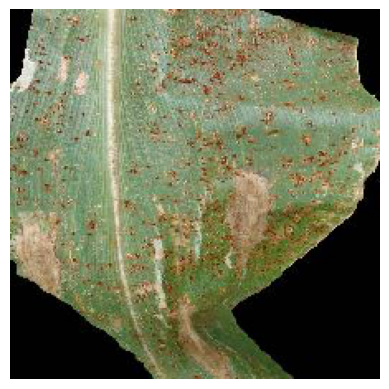

CNN MODEL:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Predictions:
Class: Common Rust, Confidence: 1.0


MOBILEV2 MODEL:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predictions:
Class: Common Rust, Confidence: 0.7118909358978271


In [8]:
# Define a function to make readable predictions
def readable_prediction(image_path, m, categories):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  
    
    predictions = m.predict(img_array)
    
    print('Predictions:')
    for pred in predictions:
        predicted_class_index = np.argmax(pred)
        confidence = np.max(pred)
        predicted_class_label = categories[predicted_class_index]
        print(f"Class: {predicted_class_label}, Confidence: {confidence}")

def get_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')        
    plt.show()

image_path = 'Corn (Maize)/Val/Common Rust/RS_Rust 1659.JPG'
categories = ['Cercospora Leaf Spot', 'Common Rust', 'Healthy', 'Northern Leaf Blight']

get_image(image_path)

print('CNN MODEL:')
readable_prediction(image_path, cnn_model, categories)
print('\n')
print('MOBILEV2 MODEL:')
readable_prediction(image_path, model, categories)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.9479 - loss: 0.1361
Test accuracy: 0.9510869383811951
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step
Confusion Matrix for MobileNetV2:
[[37  0  0  4]
 [ 0 48  0  0]
 [ 0  0 47  0]
 [ 5  0  0 43]]


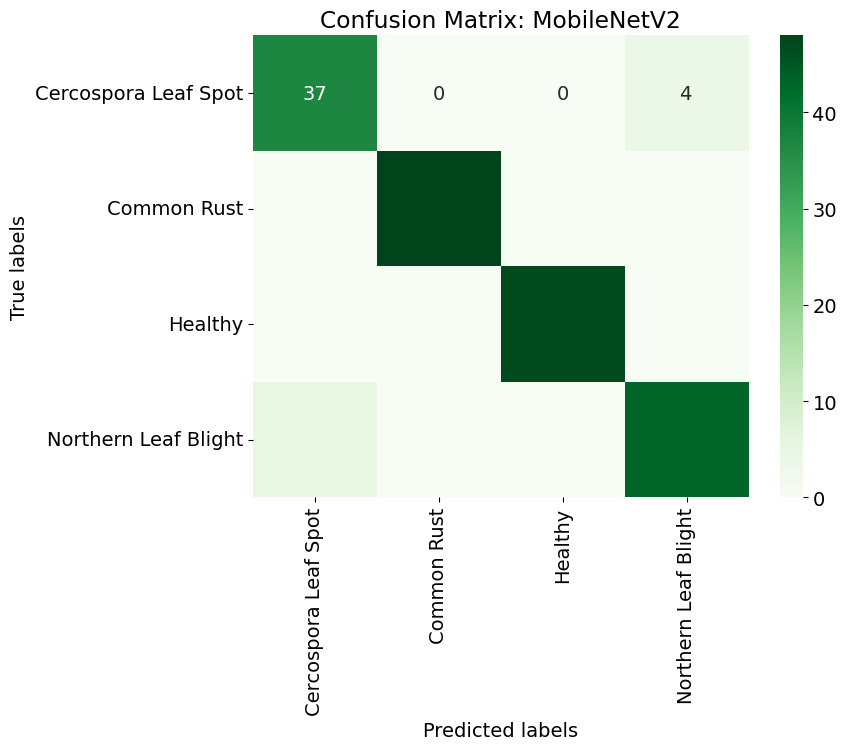

In [9]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Predict on test data
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded labels to integer labels
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix for MobileNetV2:')
print(conf_matrix)

class_labels = ['Cercospora Leaf Spot', 'Common Rust', 'Healthy', 'Northern Leaf Blight']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix: MobileNetV2')
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9438 - loss: 0.3403
Test accuracy: 0.95652174949646
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Confusion Matrix for CNN:
[[36  0  0  5]
 [ 0 48  0  0]
 [ 0  0 47  0]
 [ 1  1  1 45]]


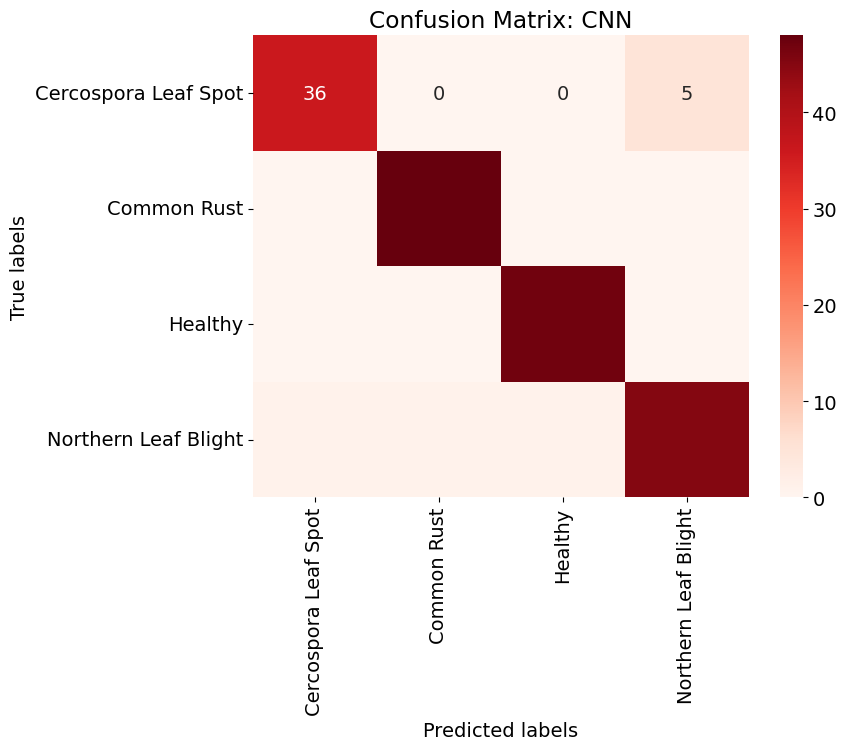

In [10]:
test_loss, test_acc = cnn_model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Predict on test data
y_pred_probs = cnn_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded labels to integer labels
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix for CNN:')
print(conf_matrix)

class_labels = ['Cercospora Leaf Spot', 'Common Rust', 'Healthy', 'Northern Leaf Blight']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Reds', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix: CNN')
plt.show()